### Function Calling

**Function Calling** / tool calling is a feature provided by LLM models to integrate specific tools when user prompts  
This becomes handy when we build a RAG pipeline with structured data  
Structured data RAG typically requires multiple pass to LLM, hence this feature will be helpful  

**Mechanism**
>In short the mechanism of funtion call revolves around providing a specific tool as a function for LLM to use  
>Define the feature / functionality you want to provide as a capability to LLM as a function  
>Provide the details of purpose and usage, which can be interpreted by LLM  
>When user prompts, LLM will take a call to use the tool based on the need and description provided  
>The output from tool then integrated as additional data to respond to the prompt

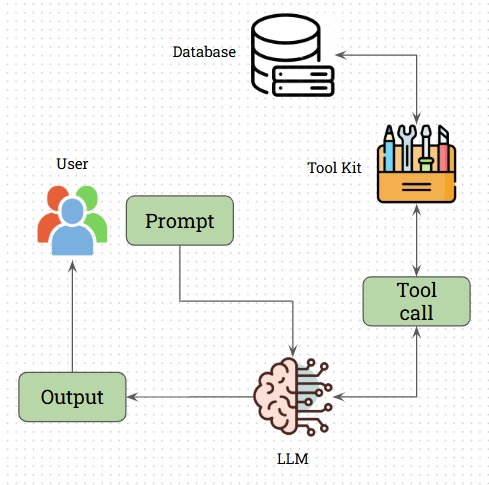

**Relevant Imports**

In [1]:
from sqlalchemy import create_engine, text, Result
import json
import csv
from groq import Groq
from dotenv import load_dotenv
import io
import openai

**Connection and Model**  
Create SQL Engine connection to the SQLite database  
Groq models support function calling features as well  
The API interface is similar with OpenAI  

In [2]:
load_dotenv ()
sql_engine = create_engine("sqlite:///Sample_2 - Copy.db")
conn = sql_engine.connect ()

client = Groq()
model = "llama3-70b-8192"

# client = openai.OpenAI ()
# model = "gpt-4o-mini"

**CSV Util**  
Function to covert the SQL query result into CSV formatted text  
In case of function calling multiple interaction might happen with LLM & more data would go in message  
Its important to have information compacted

In [4]:
def result_to_csv_string(result: Result, delimiter: str = ',') -> tuple[str, int]:
    """
    Convert qeury result to CSV-formatted string.

    Args:
        result (Result): The result of conn.execute().
        delimiter (str): Delimiter used in CSV (default is comma).

    Returns:
        tuple: (CSV string including headers, number of data rows)
    """

    # Get column names
    headers = result.keys()

    # Get all rows
    rows = result.fetchall()

    # Use StringIO to build CSV string
    output = io.StringIO()
    writer = csv.writer(output, delimiter=delimiter)

    # Write headers and data rows
    writer.writerow(headers)
    writer.writerows(rows)

    csv_string = output.getvalue()
    row_count = len(rows)

    return csv_string, row_count

**Function definiton**  
The function definition for fetching SQL data and provide as output  
This will be called by LLM upon providing required information and based on need

In [5]:
def Get_Data (SQL_Query : str) -> str:

    """ 
    This function provides data extracted from SQL database.
    Provided the SQL query, it fetches the data and returns it as CSV formatted string
    """

    try:
        # Query from DB for the provided SQL query
        result = conn.execute (text(SQL_Query))

        # The output is then convereted into CSV text
        CSV_Result, Nb_Rows = result_to_csv_string (result)

        # Return the query result ass CSV text
        # print (CSV_Result)
        return CSV_Result

    except Exception:
        return ("Error while fetching the data")

**Toolkit**  
Provide information about the function as a 'Tool'  
This shall clearly state function name, arguments, functional description etc  
There can be multiple tools provided in the tool kit

In [6]:
# Tool definition of function in a specific format as dict
# this provides details about function signature, so that LLM can understand the purpose of tool and how to use it
tools = [
    {
        "type": "function",
        "function": {
            "name": "Get_Data",
            "description": "Fetches data from SQLite database for a provided SQL query. Returns the data in CSV formatted text",
            "parameters": {
                "type": "object",
                "properties": {
                    "SQL_Query": {"type": "string", "description" : "SQL query to get the data"},
                },
                "required": ["SQL_Query"]
            }
        }
    }
]

**Schema**
Schema provided in CSV formatted text with sample data  
Sample data will help the LLM to understand the database better

In [7]:
Schema = """
Column_Name,Type,Sample_Content
student_id,VARCHAR(50),S1000
age,INTEGER,23
gender,VARCHAR(50),Female
study_hours_per_day,REAL,0.0
social_media_hours,REAL,1.2
netflix_hours,REAL,1.1
part_time_job,VARCHAR(50),No
attendance_percentage,REAL,85.0
sleep_hours,REAL,8.0
diet_quality,VARCHAR(50),Fair
exercise_frequency,INTEGER,6
parental_education_level,VARCHAR(50),Master
internet_quality,VARCHAR(50),Average
mental_health_rating,INTEGER,8
extracurricular_participation,VARCHAR(50),Yes
exam_score,REAL,56.2
"""

**Instruction**  
Instruction adapted to provide task to be done and tool usage  
specific instructions for SQL also provided  

In [8]:
R_Instr = """
           You are an SQL expert and helpful assistant.
           Answer to the question based on the data available through the tool.
           From the schema and table name given, understand the table structure clearly.
           Use the tool to fetch the required data to answer user question.
           Provide response based on data.
           
           **Instructions**:            
           Use your SQL expertise and write efficient queries.
           Query for required information.
           Its SQLite DB. Schema is provided as comma seperated text.
           When you use Text fields, always convert to lower case and use wild card : %xxx% """

**Invoke LLM with tool**  
While invoking LLM, along with instructions and prompt, the toolkit data is provided  
Depending on need, LLM uses the tool by tool call  
Tool call is resolved by code again and result passed on to LLM  
LLM provides response based on query and data fed

In [ ]:
Prompt = "Average score of girls whose parents have done masters"
# Prompt = "How much on an average boys spend online?"
# Prompt = "Who spends more time on line - Boys or Girls?"
# Prompt = "What do students with higher score do differently?"

# First stage message with prompt and instructions
messages = [
        {"role": "system", 
         "content": R_Instr},
        
        {"role": "system", 
         "content": "Table Name : Student_Performance \n Schema :\n"+Schema},
        
        {"role": "user", 
         "content": Prompt}
]

# Invoke includes the tool kit
response = client.chat.completions.create(    
    model=model,
    messages=messages,
    tools=tools,
    tool_choice="auto"
)

# Check the message received at this stage
msg = response.choices[0].message
print (msg)

# Resolve the tool call from the 1st response 
if msg.tool_calls:
    
    # Depending on question LLM may place multiple tool call request
    for tool_call in msg.tool_calls :    
        
        # extract the arguments (in our case, that's the SQL query)
        args = json.loads(tool_call.function.arguments)
        function = globals()[tool_call.function.name]
        result = function(**args)

        # Include the query result in the context and invoke LLM again (2nd stage)
        messages.append(msg)
        messages.append({
            "role": "tool",
            "tool_call_id": tool_call.id,
            "name": tool_call.function.name,
            "content": str(result)
        })

    # Final output
    final_response = client.chat.completions.create(
        model=model,
        messages=messages
    )

    print(final_response.choices[0].message.content)
else:
    print(msg.content)